<center>
<h1>Python Mini-project</h1>
<br>
<h2>Predictive Analytics using Python (CIS432)</h2>
</center> 


## Mini-project 1

__Goal:__ The goal of this assignment is to conduct a study that compares the performance of various classification algorithms on a variety of datasets. 

__Datasets:__ The folder data contains 98 publicly available datasets from the UCI machine learning repository ([link](http://archive.ics.uci.edu/ml/index.php)). These datasets were collected and converted to a standard format by Dunn and Bertsimas (for more details see [link1](https://github.com/JackDunnNZ/uci-data) and [link2](http://jack.dunn.nz/papers/OptimalClassificationTrees.pdf)):
* Each dataset is stored in a separate folder
* Each folder contains a datafile and the configuration file config.ini specifying the data format
- Data files are stored in csv format and their names either end with ".orig" or at ".custom". If both files exist in a folder, use the file ending with ".custom"
- Each config.ini file contains information about a dataset: 
    - separator: the character used to separate columns in the respective csv file
    - header_lines: the number of rows to be skipped in the datafile as these contain some information about the file but not data
    - target_index: the column number of the output variable
    - value_indices: the column numbers of the input variables
    - categoric_indices: column numbers of categorical data
    



__Remarks__:
1. Notice that column numbering in the configuration files begins with 1 (versus 0 in Python)
2. You may use the package [configparser](https://docs.python.org/3.7/library/configparser.html) to read and parse config.ini files
3. The character "?" denotes a null value. After reading a data file, you may drop all lines that contain null values.
4. Out of the 98 datasets, use only the 54 datasets whose name is stored in the file "datasets_selection".



__Assignment__: compare the performance of the following classification algorithms on the 54 datasets: 
- Support vector machine, 
- Logistic Regression, 
- K-nearest neighbors, 
- Decision trees, 
- Quadratic discriminant analysis, 
- Random forests, and 
- AdaBoost


Submit your solution as a jupyter notebook and include in your submission other files that may be needed to replicate your analysis. In addition, submit a report (at most 4 pages long) that discusses your methodology, key findings, as well as the limitations of your analysis. Compare the use of ML methods in this project against typical ML applications. 


# Solution

In [17]:
import numpy as np
import pandas as pd
import configparser
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Data Processing

In [18]:
config = configparser.ConfigParser()

import os

def ConfigRead(file):
    global name, head, sep, categoric, target, values
    if file == "breast-cancer-wisconsin":
        file = "breast-cancer-wisconsin-original"
    
    path = ('data/' + file + "/config.ini")
    if os.path.isfile(path):
        config.read(path)
        name = config['info']['name']
        head = int(config['info']['header_lines'])
        sep = config['info']['separator']
        categoric = config['info']['categoric_indices']
        target = config['info']['target_index']
        values = config['info']['value_indices']

In [19]:
def GetData(file):
    global df
    if file == "breast-cancer-wisconsin":
        file = "breast-cancer-wisconsin-original"
    
    d = str(max(os.listdir('data/' + file), key=len))
    if sep == "comma":
        df = pd.read_csv('data/' + file + '/' + d, sep=',', skiprows=head, header=None, na_values=["?"])
    elif sep == ";":
         df = pd.read_csv('data/' + file + '/' + d, sep=';', skiprows=head, header=None, na_values=["?"])
    else:
        df = pd.read_csv('data/' + file + '/' + d, sep='\s+', skiprows=head, header=None, na_values=["?"])
    return df

In [20]:
def DataClean(df):
    global train_x, test_x, train_y, test_y
    
    df.dropna(inplace=True)
    new_target = int(target)-1 # y
    value_list = [int(s)-1 for s in values.split(',')] # x

    x = df.iloc[:, value_list] # extract x
    y = df.loc[:, new_target] # extract y
    
    if categoric != '':
        categoric_list = [int(s)-1 for s in categoric.split(',')] # categorical x
        x_new = pd.get_dummies(x, columns= categoric_list, drop_first=True) # Categorical Transform X
    else:
        x_new = x

    encoder = LabelEncoder()
    y_new = encoder.fit_transform(y) # Categorical Transform Y

    train_x, test_x, train_y, test_y = train_test_split(x_new, y_new, test_size=0.2, random_state=1)
    return train_x, test_x, train_y, test_y

# Model Selection

In [21]:
# Random Forest
def RamdomForest(train_x,train_y):
    global new_rfc
    rfc = RandomForestClassifier()
    param_grid = {'n_estimators': [10,50,100],'max_features': ['auto', 'sqrt', 'log2']}
    
    grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(train_x,train_y)
    new_rfc = grid_search.best_estimator_

In [22]:
# Logistic Regression
def LogisticsRegression(train_x,train_y):
    global new_lr
    lr = LogisticRegression()
    param_grid = {'C': [10,50,100]}
    
    grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(train_x,train_y)
    new_lr = grid_search.best_estimator_

In [23]:
# Adaboost
def AdaBoost(train_x,train_y):
    global new_abc
    abc = AdaBoostClassifier()
    param_grid = {'n_estimators': range(3,10,1)}
    
    grid_search = GridSearchCV(abc, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(train_x,train_y)
    new_abc = grid_search.best_estimator_

In [24]:
# KNN 
def KNN(train_x,train_y):
    global new_knn
    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': range(1,10,1),'weights':('uniform','distance')}
    
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(train_x,train_y)
    new_knn = grid_search.best_estimator_

In [25]:
# Decision Tree
def DecisionTree(train_x,train_y):
    global new_dt
    dt = DecisionTreeClassifier()
    param_grid = {'max_depth':range(10,60,10),'criterion':('gini','entropy')}
    
    grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(train_x,train_y)
    new_dt = grid_search.best_estimator_

In [26]:
# QDA
def QDA(train_x,train_y):
    global new_qda
    qda = QuadraticDiscriminantAnalysis()
    param_grid = {'tol':[0.0001,0.001,0.01]}
    
    grid_search = GridSearchCV(qda, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(train_x,train_y)
    new_qda = grid_search.best_estimator_

In [27]:
# SVM
def svm(train_x,train_y):
    global new_svm
    svm = SVC(kernel='rbf')
    param_grid = {'C':[0.02, 0.05, 0.1, 1]}
    
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(train_x,train_y)
    new_svm = grid_search.best_estimator_ 

In [28]:
def ModelSelect(train_x, train_y, test_x, test_y):
        
    svm(train_x, train_y)
    LogisticsRegression(train_x, train_y)
    KNN(train_x, train_y)
    DecisionTree(train_x, train_y)
    QDA(train_x, train_y)
    RamdomForest(train_x, train_y)
    AdaBoost(train_x, train_y)
    
    names = ["SVM", "Logistic Regression", "KNN", "Decision Tree", "QDA", "Random Forest", "AdaBoost"]
    classifiers = [
        new_svm,
        new_lr,
        new_knn,
        new_dt,
        new_qda,
        new_rfc,
        new_abc]
    
    results={}
    for name, clf in zip(names, classifiers):
        train_predictions = clf.predict(test_x)
        score = accuracy_score(test_y, train_predictions)
        results.setdefault(name,[]).append(score)
        df_results = pd.DataFrame.from_dict(results, orient='columns')
    return df_results

# Find Best Model

In [47]:
import warnings
warnings.filterwarnings("ignore")

alldata = !cat datasets_selection
alldata = [alldata[i][:-5] for i in range(54)]

df_accuracy = pd.DataFrame()
for i in range(54):
    ConfigRead(alldata[i])
    GetData(alldata[i])
    DataClean(df)
    df_results = ModelSelect(train_x, train_y, test_x, test_y)
    df_accuracy = df_accuracy.append(df_results, ignore_index=True)
    
df_accuracy

,AdaBoost,Decision Tree,KNN,Logistic Regression,QDA,Random Forest,SVM
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.824000,0.752000,0.872000,0.832000,0.896000,0.824000,0.864000
3,0.974545,0.992727,1.000000,0.992727,0.978182,0.996364,1.000000
4,0.793333,0.746667,0.740000,0.746667,0.440000,0.740000,0.726667
5,0.894737,0.964912,0.929825,0.964912,0.956140,0.956140,0.631579
6,0.970803,0.948905,0.985401,0.985401,1.000000,1.000000,0.992701
7,0.666667,0.564103,0.589744,0.743590,0.717949,0.666667,0.717949
8,0.806358,0.927746,0.852601,0.907514,0.170520,0.907514,0.893064
9,0.925000,0.993750,0.967187,0.978125,0.582812,0.993750,0.925000


In [72]:
df_accuracy['Dataset']=alldata
df_accuracy = df_accuracy.set_index('Dataset')
df_accuracy

,AdaBoost,Decision Tree,KNN,Logistic Regression,QDA,Random Forest,SVM
Dataset,,,,,,,
acute-inflammations-1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
acute-inflammations-2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
balance-scale,0.824000,0.752000,0.872000,0.832000,0.896000,0.824000,0.864000
banknote-authentication,0.974545,0.992727,1.000000,0.992727,0.978182,0.996364,1.000000
blood-transfusion-service-center,0.793333,0.746667,0.740000,0.746667,0.440000,0.740000,0.726667
breast-cancer-wisconsin-diagnostic,0.894737,0.964912,0.929825,0.964912,0.956140,0.956140,0.631579
breast-cancer-wisconsin,0.970803,0.948905,0.985401,0.985401,1.000000,1.000000,0.992701
breast-cancer-wisconsin-prognostic,0.666667,0.564103,0.589744,0.743590,0.717949,0.666667,0.717949
car-evaluation,0.806358,0.927746,0.852601,0.907514,0.170520,0.907514,0.893064


# Model Performance

In [91]:
from collections import Counter
model=[]
for i in range(54):
    line = df_accuracy.iloc[i]
    model.append(line.index[line == line.max()].tolist()) # For each dataset, find the model with highest accuracy

flat_list = [item for sublist in model for item in sublist]
Counter(flat_list) 

Counter({'AdaBoost': 7,
         'Decision Tree': 14,
         'KNN': 12,
         'Logistic Regression': 16,
         'QDA': 12,
         'Random Forest': 22,
         'SVM': 13})

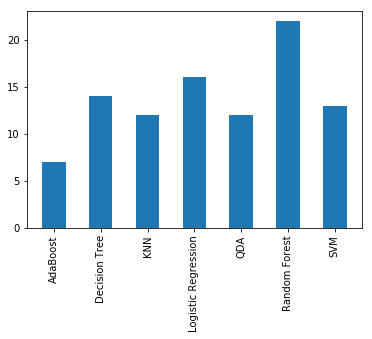

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline 

labels, values = zip(*Counter(flat_list).items())

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width)
plt.xticks(indexes, labels,rotation='vertical')
plt.show()